<div class="alert alert-info" align = "center"> <h1> KCHOUSE - Machine Learning Models </h1> </div>

---
---
<a id="introduction"></a>
[content table](#content_table)

# <font color=red> 1. Introduction
    
This notebook uses the following ML models to predict house price:
1. Decision Trees
2. Random Forest
3. Gradient Boosting Trees
4. XGBoost
5. DNN

---
---
<a id="setup"></a>
[content table](#content_table)
# <font color=red> 2. Setup

### <font color=blue> 2.1. Import library

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
from pathlib import Path
import os

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Dataframe manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, Normalizer, scale

# Modelling Helpers:
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate
from sklearn.feature_selection import RFECV

# statsmodels
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels as statm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import math
from math import sqrt

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost
from xgboost import XGBRegressor

# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.svm import SVR
import xgboost as xgb

# other utilities
import joblib
import datetime

C:\Users\Mai\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### <font color=blue> 2.2. Configuration

In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# sns.set(style = 'whitegrid',context = 'notebook')
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


### <font color=blue> 2.3. Define utility function

In [3]:
# helper function for plotting residual plots
def plot_residual(ax1, ax2, ax3, ax4, y_pred, y_real, line_label, title):
    ax1.scatter(y_real, y_pred, color='blue',alpha=0.6,label=line_label)
    ax1.set_ylabel('Predicted Y') 
    ax1.set_xlabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,y_real - y_pred, color='green',marker='x',alpha=0.6,label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')
    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    stats.probplot(y_real - y_pred, plot=ax4)
    ax4.set_title('Q-Q plot of residual values')
    
    return ax1, ax2, ax3, ax4


def performance_evaluation(X_train, X_test, y_train, y_test, model):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print('Train mse: {}'.format(mean_squared_error(y_train, pred_train)))
    print('Train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
    print()
    print('Test mse: {}'.format(mean_squared_error(y_test, pred_test)))
    print('Test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

In [4]:
data_path = r'C:\Users\Mai\OneDrive\99-MW\05_DataAnalysis\01_KCHouse\\'
training_path = r'C:\Users\Mai\OneDrive\99-MW\05_DataAnalysis\01_KCHouse\training\\'
scaler_path = os.path.join('kchouse_scaler.pkl')

---
---
<a id="setup"></a>
[content table](#content_table)
# <font color=red> 3. Load data

### <font color=blue> 3.1. Load data

In [5]:
file_name = 'kc_house_data.csv'

df = pd.read_csv(file_name)
print(df.shape)

df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### <font color=blue> 3.2.  Define and seperate variables for preprocessing

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

print(train_df.shape, test_df.shape)

(17290, 21) (4323, 21)


### <font color=blue> 3.3. Data Processing
    
This section is to perform data preprocessing which are identified after exploratory data analysis step. Instead of just doing this manually, it is more useful to create functions, for several good reasons:

+ This allows to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset)

+ Gradually build a libray of transformation functions that can be reused in future projects

+ Use these functions in live system to transform the new data before feeding it to your algorithms

+ This will make it possible to easily try various transformations and see which combination of transformations works best

For this dataset, these tasks will be performed for data preprocessing (refer notebook Data Exploratory Analysis for explanation):
1. Numeric data:
    + generate new var: sqft_ratio = sqft_living/sqft_living15
2. Categorical data:
    + Encode cat vars by calculating class ratio: ['zipcode']
    + Encode cat vars by creating dummy vars ['season']
3. temporal vars:
    + convert obj var to date time var: date
    + generate new var: season                                     
4. Handling missing data:
    + numeric data
    + categorical var
5. Scaling num var
                                   

In [7]:
def data_preparation(df):
    
    
    # convert column names
    df.columns = df.columns.str.lower()
    # replace space characters with '_'
    
    # convert data type
    for e in int_vars:
        df[e] = df[e].astype(int)
    for e in float_vars:
        df[e] = df[e].astype(float)
    for e in no_transform_cat_vars:
        df[e] = df[e].astype(int)
    for e in time_vars:
        df[e] = pd.to_datetime(df[e])
        
    df = df.reset_index(drop=True)
        
    return df

In [8]:
def preprocessing_training_data(df, num_vars, cat_vars, scale_flag=0, version='v1'):
    
    
    # 1. Numerical Data
    # fixing missing data
    med = df[num_vars].median()
    df = df.fillna(med)
    med = pd.DataFrame(med).reset_index()
    med.columns = ['feature','median_val']
    med.to_csv(training_path + 'median_treatment_' + version + '.csv', index=False)   
               
    # 2. Categorical data
    # fixing missing data
    if cat_vars is not None:
        mode = df[cat_vars].mode().transpose()
        df = df.fillna(mode)
        mode = pd.DataFrame(mode).reset_index()
        mode.columns = ['feature', 'mode_val']
        mode.to_csv(training_path + 'mode_treatment_' + version + '.csv', index=False)        
    # transform zipcode from categorical var to numerical var    
    ordered_label = df.groupby(['zipcode'])[target_var].median().sort_values().index
    ordinal_label = {k:i for i, k in enumerate(ordered_label, 0)}
    df['zipcode'] = df['zipcode'].map(ordinal_label)
    zipcode_df = pd.DataFrame(index=ordinal_label.keys(), data=ordinal_label.values()).reset_index()
    zipcode_df.columns = ['feature', 'order_val']
    zipcode_df.to_csv(training_path + 'zipcode_treatment_' + version + '.csv', index=False)
    num_vars = num_vars + ['zipcode']
    cat_vars = [e for e in cat_vars if e not in ['zipcode']]
    
    # 3. Temporal data
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['season'] = 'N/A'
    df['season'] = np.where(df['month'].isin([12,1,2]), 'winter', df['season'])
    df['season'] = np.where(df['month'].isin([3,4,5]), 'spring', df['season'])
    df['season'] = np.where(df['month'].isin([6,7,8]), 'summer', df['season'])
    df['season'] = np.where(df['month'].isin([9,10,11]), 'autumn', df['season'])
    
    # 4. Create dummy vars
    dummy_vars = ['season']
    dummy_df = pd.DataFrame()
    for var in dummy_vars:
        temp_df = pd.get_dummies(df[var], prefix=var, prefix_sep='_')
        dummy_df = pd.concat([dummy_df, temp_df], axis=1)
    dummy_vars = list(dummy_df.columns)
    dummy_vars_df = pd.DataFrame(dummy_vars).reset_index()
    dummy_vars_df.columns = ['index','feature']
    dummy_vars_df.to_csv(training_path + 'dummy_vars_' + version + '.csv', index=False)
    
    # 5. Create new/derived features
    df['sqft_total'] = df['sqft_lot'] + df['sqft_living']
    ratio_vars = ['sqft_living','sqft_lot','sqft_total']
    for var in ratio_vars:
        ordered_label = df.groupby(['zipcode'])[var].median()
        ordinal_label = dict(zip(ordered_label.index, ordered_label.values))
        df['avg_' + var] = df['zipcode'].map(ordinal_label)
        df[var + '_ratio'] = df[var]/df['avg_' + var]
        num_vars = num_vars + ['avg_'+var, var+'_ratio']
        med_df = pd.DataFrame(index=ordinal_label.keys(), data=ordinal_label.values()).reset_index()
        med_df.columns = ['zipcode', 'median_val']
        med_df.to_csv(training_path + var+'_median_' + version + '.csv', index=False)
     
    final_train_vars = num_vars + cat_vars + dummy_vars
    final_train_vars = pd.DataFrame(final_train_vars).reset_index()
    final_train_vars.columns = ['index','feature']
    final_train_vars.to_csv(training_path + 'final_train_vars_' + version + '.csv', index=False)
    
    #6. Scale numeric data
    if scale_flag == 1:
        scaler = MinMaxScaler()
        scaler.fit(df[num_vars])
        joblib.dump(scaler, scaler_path)  
        df[num_vars] = pd.DataFrame(scaler.transform(df[num_vars]), columns=num_vars)
    
    return_df = pd.concat([df[num_vars], df[cat_vars], dummy_df], axis=1)
    return return_df


In [9]:
def preprocessing_test_data(df, num_vars, cat_vars, scale_flag=0, version='v1'):
    
    # 1. Numerical data
    med_df = pd.read_csv(training_path + 'median_treatment_' + version + '.csv')
    med = pd.Series(med_df['median_val'])
    med.index = med_df['feature']
    df = df.fillna(med)
    
    # 2. Categorical data
    if cat_vars is not None:
        mode_df = pd.read_csv(training_path + 'mode_treatment_' + version + '.csv')
        mode = pd.Series(mode_df['mode_val'])
        mode.index = mode_df['feature']
        df = df.fillna(mode)
    # transform zipcode from categorical var to numerical var 
    zipcode_df = pd.read_csv(training_path + 'zipcode_treatment_' + version + '.csv')
    ordinal_label = dict(zip(zipcode_df['feature'], zipcode_df['order_val']))
    df['zipcode'] = df['zipcode'].map(ordinal_label)
    num_vars = num_vars + ['zipcode']
    cat_vars = [e for e in cat_vars if e not in ['zipcode']]    
    
    # 3. Temporal data
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['season'] = 'N/A'
    df['season'] = np.where(df['month'].isin([12,1,2]), 'winter', df['season'])
    df['season'] = np.where(df['month'].isin([3,4,5]), 'spring', df['season'])
    df['season'] = np.where(df['month'].isin([6,7,8]), 'summer', df['season'])
    df['season'] = np.where(df['month'].isin([9,10,11]), 'autumn', df['season'])   
    
    # 4. Create dummy vars
    dummy_vars = ['season']
    dummy_df = pd.DataFrame()
    for var in dummy_vars:
        temp_df = pd.get_dummies(df[var], prefix=var, prefix_sep='_')
        dummy_df = pd.concat([dummy_df, temp_df], axis=1)    
    dummy_vars = pd.read_csv(training_path + 'dummy_vars_' + version + '.csv')
    dummy_vars = dummy_vars['feature']
    for var in dummy_df.columns:
        if var not in dummy_vars:
            dummy_df[var] = 0
        
    # 5. Create new/derived features
    df['sqft_total'] = df['sqft_lot'] + df['sqft_living']
    ratio_vars = ['sqft_living','sqft_lot','sqft_total']
    for var in ratio_vars:        
        med_df = pd.read_csv(training_path + var+'_median_' + version + '.csv')
        ordinal_label = dict(zip(med_df['zipcode'], med_df['median_val']))
        df['avg_' + var] = df['zipcode'].map(ordinal_label)
        df[var + '_ratio'] = df[var]/df['avg_' + var]
        num_vars = num_vars + ['avg_'+var, var+'_ratio']   
    
    #6. Scale numeric data   
    if scale_flag == 1:
        scaler = joblib.load(scaler_path)
        df[num_vars] = pd.DataFrame(scaler.transform(df[num_vars]), columns=num_vars)

    return_df = pd.concat([df[num_vars], df[cat_vars], dummy_df], axis=1)
    return return_df

In [10]:
removed_vars = []
target_var = 'price'
id_vars = ['id']
cat_vars = ['zipcode', 'waterfront']
time_vars = ['date']
text_vars = []
num_vars = [e for e in df.columns if e not in removed_vars + [target_var] + id_vars + cat_vars + time_vars + text_vars]

float_vars = ['bathrooms','floors','lat','long']
int_vars = [e for e in num_vars if e not in float_vars]
no_transform_cat_vars =  ['zipcode', 'waterfront']
transform_cat_vars = []

train_df = data_preparation(train_df)
test_df = data_preparation(test_df)

In [11]:
y_train = train_df[target_var]
y_test = test_df[target_var]

X_train = preprocessing_training_data(train_df, num_vars, cat_vars)
train_vars = pd.read_csv(training_path + 'final_train_vars_' + 'v1' + '.csv')
train_vars = list(train_vars.feature)
X_train = X_train[train_vars]
X_test = preprocessing_test_data(test_df, num_vars, cat_vars)
X_test = X_test[train_vars]
print(X_train.shape, X_test.shape)

(17290, 28) (4323, 28)


In [12]:
final_train = X_train.copy()
final_train[target_var] = y_train
final_test = X_test.copy()
final_test[target_var] = y_test
print(final_train.shape, final_test.shape)

final_train.to_csv('v1_' + 'kc_house_train.csv', index=False)
final_test.to_csv('v1_' + 'kc_house_test.csv', index=False)

(17290, 29) (4323, 29)


In [13]:
#train_data = 'KC_House_train_data.csv'
#test_data = 'KC_House_test_data.csv'
train_data = 'v1_kc_house_train.csv'
test_data = 'v1_kc_house_test.csv'

train_df = pd.read_csv( train_data)
print(train_df.shape)

test_df = pd.read_csv(test_data)
print(test_df.shape)

train_df.head()

(17290, 29)
(4323, 29)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,zipcode,avg_sqft_living,sqft_living_ratio,avg_sqft_lot,sqft_lot_ratio,avg_sqft_total,sqft_total_ratio,waterfront,season_autumn,season_spring,season_summer,season_winter,price
0,3,1.0,1570,5510,1.0,0,4,7,1070,500,1940,0,47.6942,-122.319,1770,6380,51,1720.0,0.912791,5130.5,1.073969,7085.0,0.999294,0,0,0,0,1,495000.0
1,3,2.5,1780,11000,1.0,0,4,8,1210,570,1980,0,47.5574,-122.149,2310,9700,65,2790.0,0.637993,10473.0,1.050320,13230.0,0.965986,0,0,0,1,0,635000.0
2,3,1.5,1090,9862,1.0,0,3,8,1090,0,1987,0,47.6256,-122.036,1710,9862,55,2570.0,0.424125,10112.0,0.975277,12706.0,0.861955,0,0,1,0,0,382500.0
3,4,2.5,2210,7079,2.0,0,3,8,2210,0,1993,0,47.4206,-122.183,1970,7000,12,1850.0,1.194595,8017.0,0.882999,9867.5,0.941373,0,0,0,1,0,382500.0
4,3,2.5,1800,4763,2.0,0,3,7,1240,560,1985,0,47.6460,-122.362,1790,4763,63,1800.0,1.000000,3600.0,1.323056,5590.0,1.174061,0,1,0,0,0,670000.0


In [14]:
TARGET = 'price'
TRAIN_VARS = [e for e in train_df.columns if e not in [target_var]]
X_train = train_df[TRAIN_VARS]
y_train = train_df[TARGET]

X_test = test_df[TRAIN_VARS]
y_test = test_df[TARGET]

---
---
<a id="decision_tree"></a>
[content table](#content_table)
# <font color=red> 4. Decision Tree
    
### <font color=blue>4.1. Overview
1. **Idea**: Decision tree is a non-parametric model which involves stratifying or segmenting the predictor space into a number of simple regions using splitting rules based on possible values of features. The set of splitting rules used to segment the object space can usually be summarized in a tree, so these are decision tree methods  
    
2. **CART Algorithm**: For regression problem, the CART tries to construct the predictor space into J distinct and non-overlapping regions R1, R2,.,Rj that minimizes the residual sum of squares (RSS):
    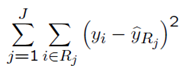
    
    + ***Node splitting***: It is top-down, greedy manner approach. The basic process tries to split data points using different attributes/features and test against a cost function. It first selects the attribute Xj and the cutpoint value s such that the splitting the object space into 2 regions R1 (j,s) = {X | Xj < s} and R2 (j,s) = {X | Xj >= s} leads to the greatest possible reduction in RSS (means we seek the values of j and s that minimize):
    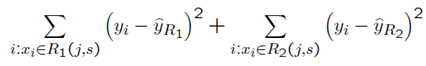
    (where y^R1 is the mean label for the training observations in R1(j,s) and y^R2 is the mean label for the training observations in R2(j,s))
    + ***Iteration***: Next, it continues looking for the best attribute and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions. However, this time, instead of splitting the entire object space, it splits one of the two previously identified regions. Now there are three regions. Again, it look to split one of these three regions further, so as to minimize the RSS. The process continues until a stopping criterion is reached such as no region contains more than five observation belongs
    + ***Prediction***: For every observation that falls into the region Rj, it make the same prediction, which is simply the mean of the label values for the training observations in Rj

### <font color=blue>4.2. Train model with default hyper-parameters
    
**No contrainsts for hyper-parameters**

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
tree_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

#### Model Performance

In [16]:
train_score = tree_model.score(X_train, y_train)
test_score = tree_model.score(X_test, y_test)

print("Train R-squared: %.4f" % train_score)
print("Test R-Squared: %.4f" % test_score)

Train R-squared: 0.9999
Test R-Squared: 0.7780


=> The model suffers from overfitting problem, it produces perfectly predict on train test (Train R-squared = 1), while it predicted much poorer on the test set (R-squared = 0.78)

=> Without any regularization (i.e., using the default hyper-parameters), Decision trees often suffers overfitting problem. This is because the tree might be too complicated and goes too deep and thus to fit details of the particluar data rather than the overall properties of the distribution they are drawn from. Thus, it is necessary to tune the model to find the best combination of hyperparameters

### <font color=blue> 4.3. Tuning hyper-parameters with Grid search and cross-validation

1. **Hyper-parameters**: Hyperparameters are the knobs and controls we set with an aim to optimize the model’s performance on unseen data. These hyperparameters are different from parameters which are learned by our learning algorithm over the course of training process. Hyperparameters help us achieve objectives of avoiding overfitting and so on. Decision trees provide us with quite a few hyperparameters to play with 
    + min_samples_split: the minimum number of samples a node must have before it can be split
    + min_samples_leaf: the minimum number of samples a leaf node must have
    + min_weight_fraction_leaf: same as min_samples_leaf but expressed as a fraction of the total number of weighted instances
    + max_leaf_nodes: maximum number of leaf nodes
    + max_features: maximum number of features that are evaluated for splitting at each node
    + increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model

    
2. **Grid search**: The actual training process for decistion tree involves using k-fold cross validation to tune hyperparameters. Grid search is one of the popular methods for this task. It is a systematic approach where all combinations of parameters are tried to find the best combination. It is important to understand that grid search with cross validation was optimizing on finding the best set of hyperparmeters that can  help prepare a generalizable Decision Tree Regressor. 
    + Hyper-parameters are defined using a dictionary. The dictionary basically provides a list of feasible values for each of the hyperparmeters that we want to fine-tune.
    + sklearn provides a utility to grid search of the hyperparameters  with k-fold cross validation is an iterative process wrapped, optimized and standardized by GridSearchCV() function from model_selection module

#### Perform 10-fold cross-validation

We train the model on the training set, and we test the accuracy of the model on the test set. That’s correct but we may have the variance problem. The variance problem can be explained by the fact that when we get the accuracy on the test set, and then we run the model again and test the performance on another test set. We can get very different accuracy. So, testing the accuracy of the model only on one training set and one test set is not good enough to evaluate the performance

K-Folds Cross Validation help to avoid underfitting as well as overfitting. The aim is to be able to generalize the model to new datasets with same accuracy. In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once

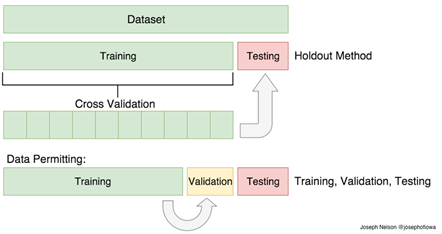


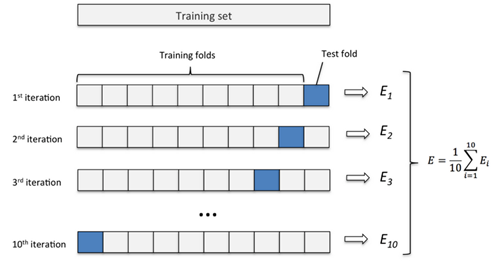

#### Performing Grid search

In [18]:
from sklearn.model_selection import GridSearchCV

# create a dictionary to define hyper-parameters and their possible values
param_grid = {
    'criterion': ['mse'],
    'min_samples_split':  [50,100],
    'min_samples_leaf': [30,60],
    'max_depth': [6,8]    
}

# create a base model
tree_model = DecisionTreeRegressor()
# Instantiate the grid search model
tree_grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=10, n_jobs=-1)
# Fit the grid search to the train data
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [6, 8],
                         'min_samples_leaf': [30, 60],
                         'min_samples_split': [50, 100]})

#### View the hyperparameters and detailed information for the model

In [19]:
# View best score
print("R-Squared: {}".format(tree_grid_search.best_score_))

# View best hyperparameters
print("Best hyperparameters: {}".format(tree_grid_search.best_params_))

# View detailed information of search iteration of GridSearchCV
gridsearch_df = pd.DataFrame(tree_grid_search.cv_results_)
gridsearch_df.head()

R-Squared: 0.7564804513021715
Best hyperparameters: {'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 30, 'min_samples_split': 50}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.379073,0.070592,0.007141,0.006620,mse,6,30,50,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.784099,0.719370,0.636473,0.759334,0.714900,0.772287,0.749276,0.763727,0.766458,0.723029,0.738895,0.040938,7
1,0.345132,0.083986,0.009141,0.006908,mse,6,30,100,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.784099,0.711074,0.646024,0.756319,0.705684,0.771648,0.747729,0.763727,0.764419,0.724924,0.737565,0.039301,8
2,0.329506,0.073401,0.003114,0.006229,mse,6,60,50,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.771549,0.707121,0.723298,0.739037,0.688354,0.739110,0.736515,0.779607,0.764812,0.750501,0.739991,0.027076,5
3,0.361778,0.061956,0.009019,0.007436,mse,6,60,100,"{'criterion': 'mse', 'max_depth': 6, 'min_samp...",0.771549,0.707121,0.723298,0.739037,0.688354,0.739110,0.736515,0.779607,0.764812,0.750501,0.739991,0.027076,5
4,0.592705,0.077378,0.009381,0.006753,mse,8,30,50,"{'criterion': 'mse', 'max_depth': 8, 'min_samp...",0.788618,0.741144,0.653019,0.775929,0.745654,0.791292,0.763780,0.774397,0.790121,0.740850,0.756480,0.039281,1


#### Train model with the best paramters

In [20]:
tree_model = tree_grid_search.best_estimator_
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=30, min_samples_split=50)

### <font color=blue>  4.4. Prediction

In [32]:
pred_train = tree_model.predict(X_train)
print('Train prediction: ', list(pred_train[0:5]))
print('Train true label: ', list(y_train[0:5]))
print()
pred_test = tree_model.predict(X_test)
print('Test prediction: ', list(pred_test[0:5]))
print('Test true label: ', list(y_test[0:5]))
print()
print('Average house price: ', y_test.mean())
print('Average predicted price: ', pred_test.mean())

Train prediction:  [489261.3333333333, 544882.0614035088, 343446.51639344264, 332049.6587837838, 667191.6296296297]
Train true label:  [495000.0, 635000.0, 382500.0, 382500.0, 670000.0]

Test prediction:  [318411.1395348837, 1350326.0526315789, 566260.6162361624, 544882.0614035088, 690078.4367816092]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  529242.6123062688
Average predicted price:  532207.709697655


### <font color=blue>  4.5. Model Evaluation

#### R-squared

In [33]:
train_score = tree_model.score(X_train, y_train)
test_score = tree_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.8088
Test R-squared: 0.7763


=> With the best hyper-parameters, the decision trees is now more generalized, leading the performance on both train set and test set are quite similar

#### MSE and RMSE

In [34]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test, pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 26515049247.73235
linear train rmse: 162834.42279730766

linear test mse: 26604516334.34291
linear test rmse: 163108.90942662486


#### Residual plot

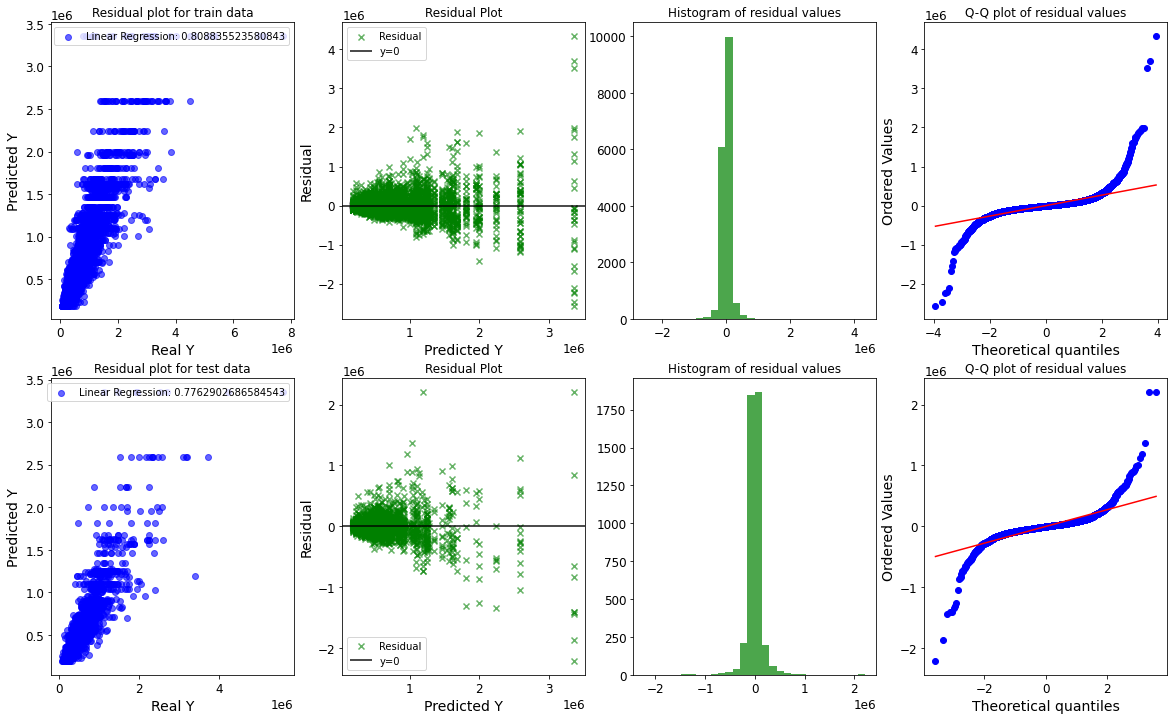

In [35]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

#### Cross validation

In [36]:
# Cross validation
cv_scores = cross_val_score(tree_model, X_train, y_train, scoring='r2', cv=10)
rmse = np.sqrt(-cross_val_score(tree_model, X_train, y_train, scoring='neg_mean_squared_error'))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ', np.round(np.mean(rmse),2))

R2 score:  [0.78861805 0.74114392 0.65301853 0.77592907 0.74565378 0.79147321
 0.76378008 0.77439733 0.79012124 0.74085028]
Average R2 score:  0.76
Average RMSE score:  185218.85


### <font color=blue>  4.6. Visualize the tree

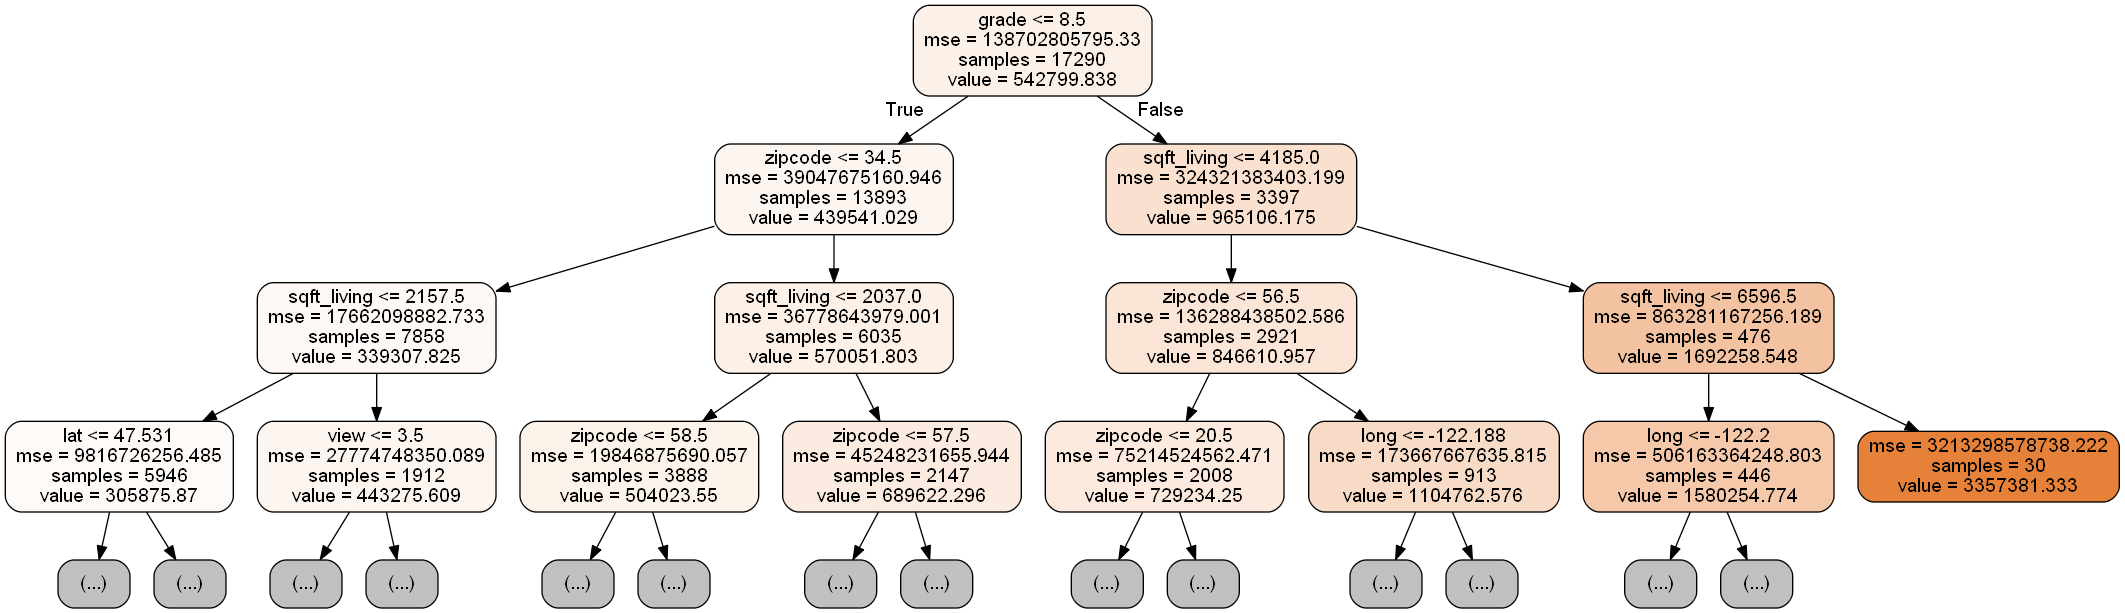

In [37]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import Image

export_graphviz(
    tree_model,
    out_file='kchouse_tree.dot',
    #out_file=None,
    feature_names = TRAIN_VARS,
    class_names = TARGET,
    special_characters=False,
    rounded=True,
    filled=True,
    max_depth=3
)

! dot -Tpng kchouse_tree.dot -o kchouse_tree.png
Image('kchouse_tree.png')

### <font color=blue>  4.7. Interpretation
    
The plot shows the root node being split on attribute `grade` and then going on until it reached a stopping criteria. This plot display nodes with depth from 1 to 3, however, the tree actually goes deeper to depth of 8 (best chosen hyperparameter).
    
The top split assigns observation having grade <= 0.625 to the left branch. The predicted price for these houses is given by the mean value of prices in the dataset with grade  <= 0.625 which is around 439,541 usd. Houses with grades > 0.625 are assigned to the right branch with the predicted price of 965,000 usd. Then these groups are further subdivided by sqft_living and zipcode

`grade` is the most important factor in determining house price, houses having grade below this grade are likely old houses and therefore have lower price. Given that houses have the same grade, `zipcode` which represents the residential region (higher zipcode value means more expensive regions since zipcode values were derived from average prices of the houses in a particular zipcode) or `sqft_living` which represents the area are used to determine the house price. 

### <font color=blue>  4.8. Feature Importance

In [38]:
# Get numerical feature importance
feature_importance = list(tree_model.feature_importances_)
feature_labels = TRAIN_VARS
# List of tuples with variable and importance
feature_importance_list = [(feature, round(importance, 2)) for feature, importance in zip(feature_labels, feature_importance)]
# Sort the featue importance by most important first
feature_importance_list = sorted(feature_importance_list, key=lambda x:x[1], reverse=True)
# Print out the feature and importance
[print('{:20} Importance: {}'.format(*pair)) for pair in feature_importance_list];

grade                Importance: 0.4
sqft_living          Importance: 0.27
zipcode              Importance: 0.19
long                 Importance: 0.05
view                 Importance: 0.03
sqft_living_ratio    Importance: 0.03
yr_built             Importance: 0.01
lat                  Importance: 0.01
sqft_living15        Importance: 0.01
bedrooms             Importance: 0.0
bathrooms            Importance: 0.0
sqft_lot             Importance: 0.0
floors               Importance: 0.0
condition            Importance: 0.0
sqft_above           Importance: 0.0
sqft_basement        Importance: 0.0
yr_renovated         Importance: 0.0
sqft_lot15           Importance: 0.0
avg_sqft_living      Importance: 0.0
avg_sqft_lot         Importance: 0.0
sqft_lot_ratio       Importance: 0.0
avg_sqft_total       Importance: 0.0
sqft_total_ratio     Importance: 0.0
waterfront           Importance: 0.0
season_autumn        Importance: 0.0
season_spring        Importance: 0.0
season_summer        Importanc

Text(0.5, 1.0, 'Variable Importances')

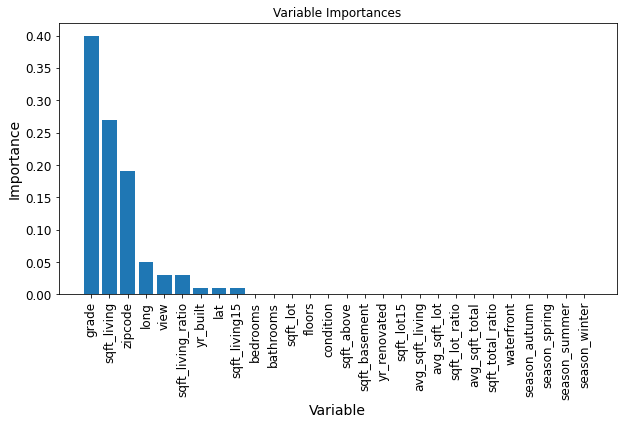

In [39]:
plt.figure(figsize=(10,5))
# list of x locations for plotting
feature_labels = [pair[0] for pair in feature_importance_list]
x_values = list(range(len(feature_labels)))
y_values = [pair[1] for pair in feature_importance_list]
# Make a bar chart
plt.bar(x_values, y_values, orientation='vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_labels, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

Text(0.5, 1.0, 'Feature Importance')

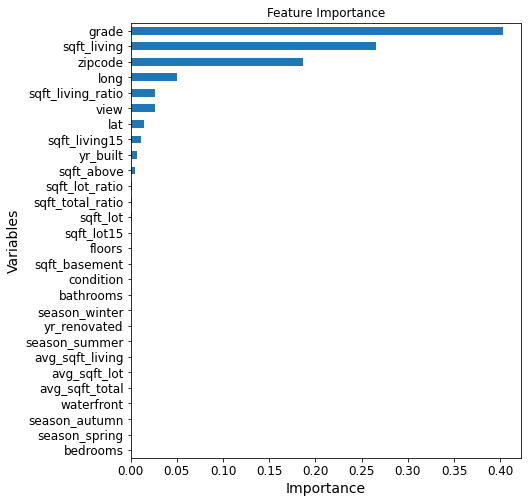

In [40]:
feature_importance = pd.Series(tree_model.feature_importances_)
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True, ascending=True)
feature_importance.plot.barh(figsize=(7,8))
plt.ylabel('Variables')
plt.xlabel('Importance')
plt.title('Feature Importance')

---
---
<a id="random_forest"></a>
[content table](#content_table)
# <font color=red>5. Random Forest
    
### <font color=blue>5.1. Overview
    
1. **Idea**: Random forests are an example of an ensemble method, meaning that it combine multiple machine learning algorithms and use the aggregation predictions to obtain better predictive performance. Random forest supports sample both data and features. More specifically, the Random Forest algorithm introduces extra randomness when growing trees instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model.
    
    
2. **Algorithm**: 
    + ***Sampling dataset***: We use bootstrap technique to generate different bootstrapped training sets (select data from the original dataset with replacement)
    + ***Build a Decision Tree with each new sample***: But when building these decision trees, each time a split in a tree is considered, choose a random sample of m attributes as split candidates from the full set of p attributes (The split is allowed to use only one of those m attributes). A fresh sample of m attributes is taken at each split. The number of predictors considered at each split is approximately equal to the square root of the total number of predictors (m ≈ sqrt(p))
    + ***Prediction***: Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors which is the average for regression

### <font color=blue>5.2. Train model with default parameters

In [41]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# default parameters
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [42]:
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9823
Test R-squared: 0.8981


### <font color=blue> 5.3. Tuning model
    
Random Forest has all the parameters of a Decision Tree (to control how trees are grown), plus all the hyperparameter of a Bagging Classifier (to control the ensemble)

#### Setting values of hyperparameters for searching 

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    # 'bootstrap': [True],
    'max_depth': [8, 10],
    'max_features': [8, 12],
    'min_samples_leaf': [30, 50],
    'min_samples_split': [100],
    'n_estimators': [300]
}
# Create a based model
rf_model = RandomForestRegressor()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2) 
# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)  

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.0min finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': [8, 12],
                         'min_samples_leaf': [30, 50],
                         'min_samples_split': [100], 'n_estimators': [300]},
             verbose=2)

#### View the hyperparameters and detailed information for the model

In [45]:
# view best score
print('R-Squared:{}'.format(rf_grid_search.best_score_))
# view best hyperparameters
print('Best hyperparameters:{}'.format(rf_grid_search.best_params_))
# view detailed information of each iteration of GridSearchCV()
gridsearch_df = pd.DataFrame(rf_grid_search.cv_results_)
gridsearch_df.head()

R-Squared:0.8099996353176758
Best hyperparameters:{'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 30, 'min_samples_split': 100, 'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,41.119433,3.205775,0.362975,0.054694,8,8,30,100,200,"{'max_depth': 8, 'max_features': 8, 'min_sampl...",0.770607,0.726865,0.826109,0.817384,0.789803,0.786847,0.813156,0.842608,0.813912,0.818924,0.800622,0.031638,4
1,44.280795,2.913285,0.412186,0.084728,8,8,50,100,200,"{'max_depth': 8, 'max_features': 8, 'min_sampl...",0.757705,0.717155,0.808188,0.811901,0.774603,0.767915,0.799058,0.828215,0.808903,0.805314,0.787896,0.031583,8
2,65.016215,2.661497,0.469281,0.109173,8,12,30,100,200,"{'max_depth': 8, 'max_features': 12, 'min_samp...",0.782799,0.734212,0.829932,0.818374,0.788834,0.796179,0.816690,0.848525,0.819159,0.822630,0.805733,0.030299,2
3,68.998202,3.497624,0.459649,0.205485,8,12,50,100,200,"{'max_depth': 8, 'max_features': 12, 'min_samp...",0.768141,0.724078,0.816388,0.813942,0.779804,0.779083,0.803603,0.835079,0.816621,0.804753,0.794149,0.030475,6
4,47.711659,2.956897,0.435084,0.121746,10,8,30,100,200,"{'max_depth': 10, 'max_features': 8, 'min_samp...",0.775290,0.731926,0.830780,0.821072,0.795577,0.791245,0.814062,0.847104,0.822379,0.822100,0.805154,0.031420,3


It is important to understand that grid search with cross validation was optimizing on finding the best set of hyperparmeters that can  help prepare a generalizable Decision Tree Regressor. 

#### Train model with the best paramters

In [46]:
rf_model = rf_grid_search.best_estimator_
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=12, min_samples_leaf=30,
                      min_samples_split=100, n_estimators=200)

### <font color=blue> 5.4. Prediction

In [47]:
pred_train = rf_model.predict(X_train)
print('Train prediction: ',list(pred_train[0:5]))
print('Train true label: ',list(y_train[0:5]))
print()
pred_test = rf_model.predict(X_test)
print('Test prediction: ',list(pred_test[0:5]))
print('Test true label: ',list(y_test[0:5]))
print()
print('Average house price: ', y_train.mean())
print('Average predicted price: ', pred_train.mean())

Train prediction:  [523025.45414160425, 573669.2456509009, 416576.3159500364, 334653.7674261492, 661880.2873283583]
Train true label:  [495000.0, 635000.0, 382500.0, 382500.0, 670000.0]

Test prediction:  [352360.8255906693, 1476979.4347862834, 544906.5387054654, 568979.2409151391, 780968.521034577]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  542799.8377674957
Average predicted price:  542483.3319266746


### <font color=blue> 5.5. Model Evaluation

#### R-squared

In [48]:
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.8307
Test R-squared: 0.8344


#### MSE, RMSE

In [49]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test,pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 23482067111.282345
linear train rmse: 153238.59537101723

linear test mse: 19688597336.733177
linear test rmse: 140316.06229057733


#### Residual plot

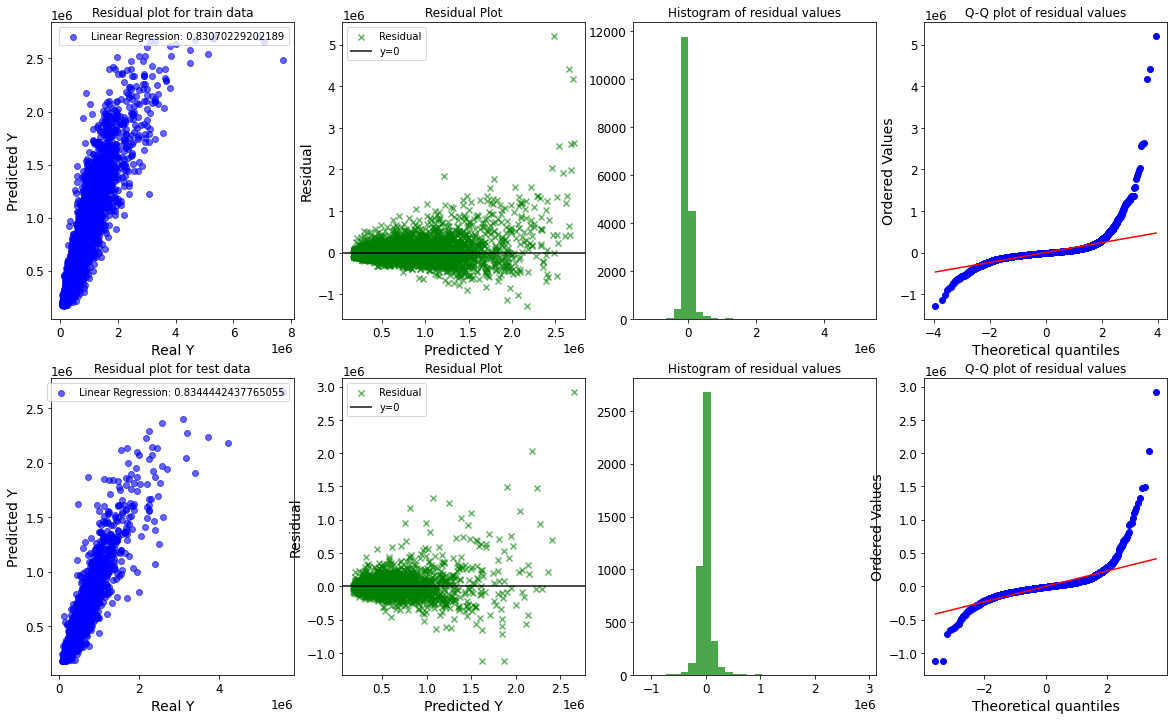

In [50]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

### <font color=blue> 5.6. Feature Importance 
    
+ It can be difficult to interpret the resulting model. When we bag a large number of trees, it is no longer possible to represent the resulting statistical learning procedure using a single tree, and it is no longer clear which variables are most important to the procedure. Thus bagging improves prediction accuracy at the expense of interpretability.

+ Although the collection of bagged trees is much more difficult to interpret than a single tree, one can obtain an overall summary of the importance of each predictor using the RSS (for bagging regresssion trees) or the Gini index (for bagging classification trees). In the case of bagging regression trees, we can record the total amount that the RSS is decreased due to splits over a given predictor, averaged over all B trees. A large value indicates an important predictor. Similarly, in the context of bagging classification trees, we can add up the total amount that the Gini index is decreased by splits over a given predictor, average over all B trees.
    
+ For this dataset, it can be seen the mean decrease in RSS index for each variable, relative to the largest. The variables with the largest mean decrease are sqft_living, grade, zipcode

Text(0.5, 1.0, 'Feature Importance')

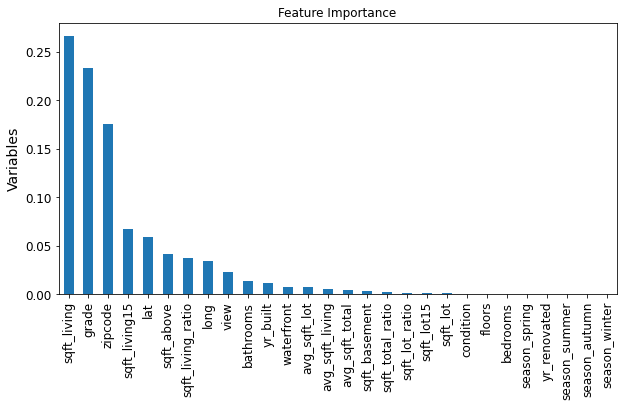

In [51]:
feature_importance = pd.Series(np.abs(rf_model.feature_importances_))
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True,ascending=False)
feature_importance.plot.bar(figsize=(10,5))
plt.ylabel('Variables')
plt.title('Feature Importance')

### <font color=blue> 5.7. Cross Validation

In [52]:
# Cross Validation
cv_scores = cross_val_score(rf_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(rf_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))

R2 score:  [0.78716647 0.73504608 0.83080295 0.82530936 0.79680646 0.80037884
 0.8221383  0.84983331 0.82422242 0.82356349]
Average R2 score:  0.81
Average RMSE score:  162330.55


---
---
<a id="gradient_boosting"></a>
[content table](#content_table)
# <font color=red>6. Gradient Boosting Tree
    
### <font color=blue>6.1. Overview
1. **Idea**: Gradient Boosting works by sequentially adding predictors to an ensemble, the current model tries to correct the mistakes from the previous model. More specifically, the method tries to fit the new predictor to negative gradient made by the previous predictor, so each base model is fit on a modified version of the original dataset
    
    
2. **Algorithm**: Boosting tree works by fitting to residuals, not to the true label. So at each iteration, the original dataset is modified with y values is residual values computed from previous model
    
    + ***Initialize*** by setting F^(x) = 0 and r = y for all data points in the training set
    + ***Fit model F*** by minimizing the mean square error
    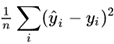
    
    + ***Repeat m=1,2,..,M***:
        + At each stage, 1 ≤ m ≤ M, of boosting, it may be assumed that there is some imperfect model Fm. The boosting algorithm improves on Fm by constructing a new model that adds an estimator h to provide a better model: 
                                    Fm+1(x) = Fm(x) + h(x)
    
        + To find h, the boosting solutions starts with the observation that a perfect h would imply
    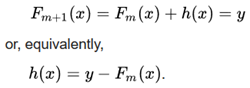
    
        + Therefore, boosting will fit h to the residual r = y – Fm(x)
    
    + ***Ouput the boosted model***
    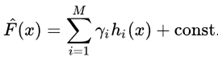

### <font color=blue>6.2. Train model with default parameters

In [53]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

gbt_model = GradientBoostingRegressor()
gbt_model.fit(X_train, y_train)

gbt_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [54]:
train_score = gbt_model.score(X_train, y_train)
test_score = gbt_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9152
Test R-squared: 0.8824


### <font color=blue> 6.3. Tuning model
    
+ **learning_rate**: scales the contribution of each tree. It you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is the regularization technique called shrinkage. If there are not enough trees to fit the training set it may cause underfitting, while if having has too many trees it may cause overfitting
    
The following codes try to fit the model with 4 different learning rates:  0.05, 0.1, 0.3, 0.5

#### Setting values of hyperparameters for searching 

In [52]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    # 'bootstrap': [True],
    'max_depth': [6],
    'max_features': [8],
    'min_samples_leaf': [50],
    'min_samples_split': [100],
    'n_estimators': [100, 200, 300, 400, 500],
}
# Create a based model
gbt_model = GradientBoostingRegressor()
# Instantiate the grid search model
gbt_grid_search = GridSearchCV(estimator = gbt_model, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2) 
# Fit the grid search to the data
gbt_grid_search.fit(X_train, y_train)  

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6], 'max_features': [8],
                         'min_samples_leaf': [50], 'min_samples_split': [100],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=2)

#### View the hyperparameters and detailed information for the model

In [56]:
# view best score
print('R-Squared::{}'.format(gbt_grid_search.best_score_))
# View best hyperparameters
print('Best hyperparameters::\n{}'.format(gbt_grid_search.best_params_))
# View detailed information of each iteration of GridSearchCV()
gridsearch_df = pd.DataFrame(gbt_grid_search.cv_results_)
gridsearch_df.head(5)

R-Squared::0.8881280936473865
Best hyperparameters::
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 500}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.041943,0.032012,0.007150,0.001413,6,8,50,100,50,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.862394,0.813232,0.890656,0.855827,0.879026,0.874888,0.886323,0.894985,0.884870,0.892617,0.873482,0.023485,3
1,8.597271,1.789640,0.016576,0.005770,6,8,50,100,200,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.884111,0.829868,0.897489,0.853190,0.888548,0.906156,0.892119,0.908274,0.889147,0.900587,0.884949,0.023496,2
2,26.978119,4.046914,0.034444,0.011730,6,8,50,100,500,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.891925,0.845518,0.897814,0.855776,0.886858,0.908492,0.904119,0.898445,0.887034,0.905299,0.888128,0.020112,1


#### View grid search results

In [57]:
results = gbt_grid_search.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 50} 0.8735 0.0235
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 200} 0.8849 0.0235
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 500} 0.8881 0.0201


#### Train model with the best paramters

In [58]:
gbt_model = gbt_grid_search.best_estimator_
gbt_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=6, max_features=8, min_samples_leaf=50,
                          min_samples_split=100, n_estimators=500)

### <font color=blue>6.4. Prediction

In [59]:
pred_train = gbt_model.predict(X_train)
print('Train prediction: ',list(pred_train[0:5]))
print('Train true label: ',list(y_train[0:5]))
print()
pred_test = gbt_model.predict(X_test)
print('Test prediction: ',list(pred_test[0:5]))
print('Test true label: ',list(y_test[0:5]))
print()
print('Average house price: ', y_train.mean())
print('Average predicted price: ', pred_train.mean())

Train prediction:  [494783.720617778, 600318.3041694249, 418157.3732879025, 326180.66566556506, 646849.4642499397]
Train true label:  [495000.0, 635000.0, 382500.0, 382500.0, 670000.0]

Test prediction:  [325088.5059183816, 1805936.1355080593, 534509.6880829347, 629579.2658331799, 649279.4328789744]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  542799.8377674957
Average predicted price:  542799.8377674957


### <font color=blue> 6.5. Model Evaluation

#### R-squared

In [60]:
train_score = gbt_model.score(X_train, y_train)
test_score = gbt_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9547
Test R-squared: 0.9028


#### MSE, RMSE

In [61]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test,pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 6282880546.940798
linear train rmse: 79264.6235526341

linear test mse: 11559652642.666523
linear test rmse: 107515.82508015516


#### Residual plot

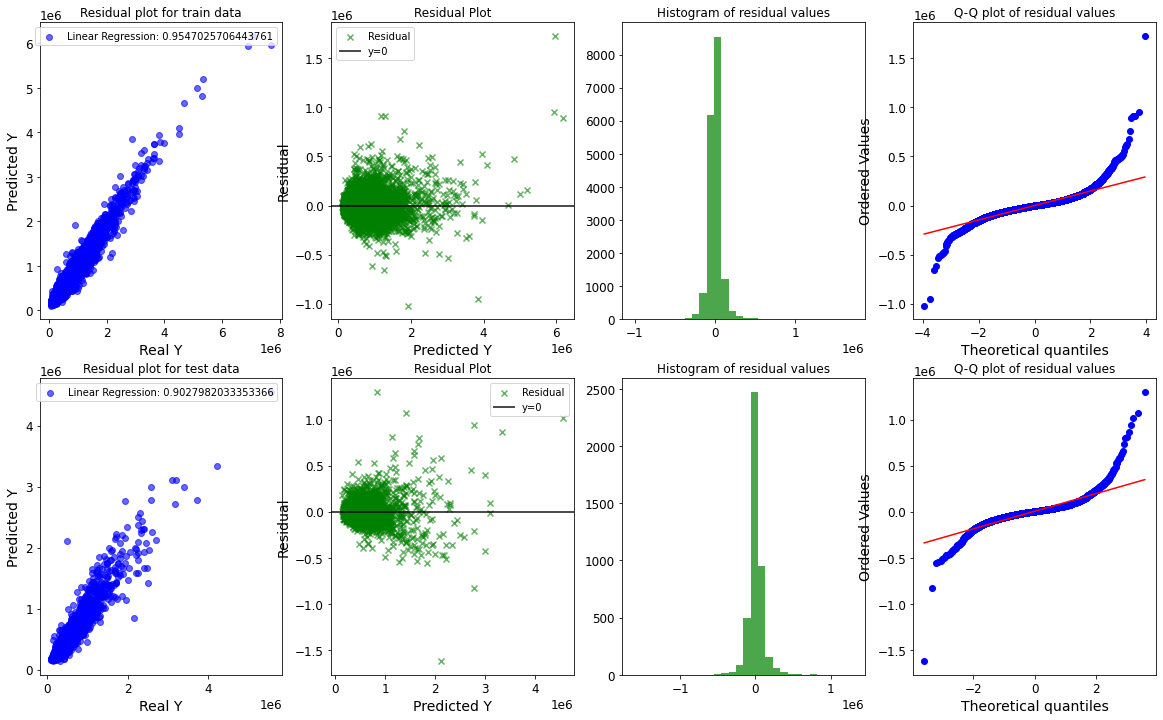

In [62]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

### <font color=blue> 6.6. Feature Importance 

Text(0.5, 1.0, 'Feature Importance')

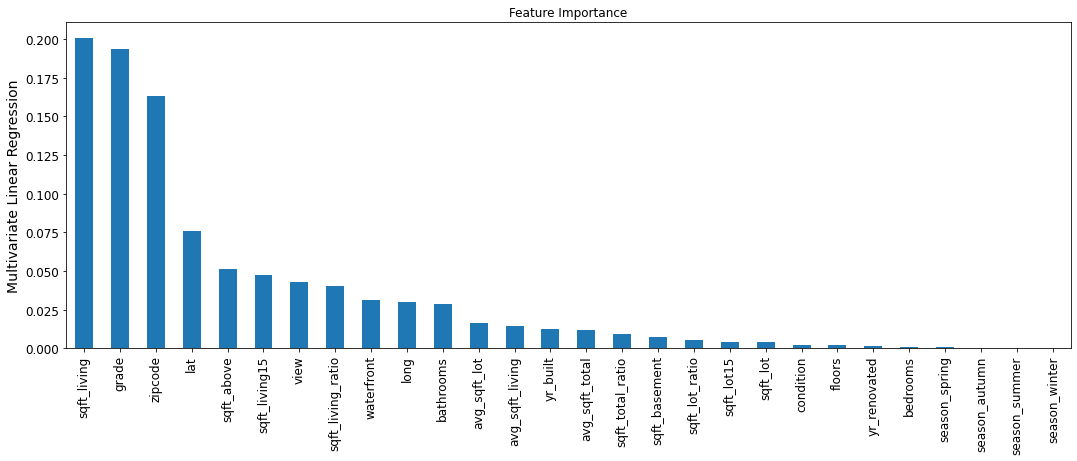

In [63]:
feature_importance = pd.Series(np.abs(gbt_model.feature_importances_))
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True,ascending=False)
feature_importance.plot.bar(figsize=(18,6))
plt.ylabel('Multivariate Linear Regression')
plt.title('Feature Importance')

### <font color=blue> 6.7. Cross Validation

In [64]:
# Cross Validation
cv_scores = cross_val_score(gbt_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(gbt_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))
pd.Series(cv_scores).describe()

R2 score:  [0.89429644 0.84306132 0.89835448 0.86140776 0.89473702 0.9051584
 0.90257314 0.89357565 0.88669916 0.90743489]
Average R2 score:  0.89
Average RMSE score:  123404.94


count    10.000000
mean      0.888730
std       0.020631
min       0.843061
25%       0.888418
50%       0.894517
75%       0.901518
max       0.907435
dtype: float64

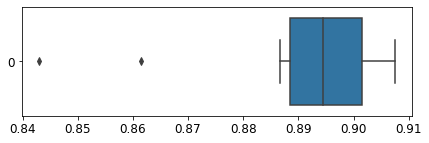

In [65]:
plt.figure(figsize=(7,2))
sns.boxplot(data=cv_scores, orient='h')
plt.show()

### <font color=blue> 6.8. Gradient Boosting with Early stopping

In [68]:
gbrt = GradientBoostingRegressor(max_depth=5, warm_start=True, random_state=42, 
                                 min_samples_leaf=50)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(300, 500, 50):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print(n_estimators, ": ", gbrt.score(X_test, y_test))
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

300 :  0.8979881786126278
350 :  0.8990526702164605
400 :  0.8997617091733419
450 :  0.901158826689155


In [69]:
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

450
Minimum validation MSE: 11754614312.415651


In [70]:
gbt_model = GradientBoostingRegressor(max_depth=5, warm_start=True, random_state=42, 
                                 min_samples_leaf=50, n_estimators=280)
gbt_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=50, n_estimators=280,
                          random_state=42, warm_start=True)

In [71]:
train_score = gbt_model.score(X_train, y_train)
test_score = gbt_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9363
Test R-squared: 0.8975


In [72]:
# Cross Validation
cv_scores = cross_val_score(gbt_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(gbt_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))

R2 score:  [0.88192994 0.83104559 0.88299302 0.85861222 0.88605444 0.907864
 0.90326049 0.89585813 0.88664853 0.89765626]
Average R2 score:  0.88
Average RMSE score:  126458.99


---
---
<a id="xgb"></a>
[content table](#content_table)
# <font color=red>7. XGBoost

### <font color=blue> 7.1. Train model

In [73]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [74]:
import xgboost
xgb_model = xgb.XGBRegressor(max_depth=5,n_estimators=50)
xgb_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 50,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [75]:
xgb_model.fit(X_train,y_train, eval_set = [(X_train, y_train), (X_validation, y_validation)])

[0]	validation_0-rmse:288283.91889	validation_1-rmse:306325.51769
[1]	validation_0-rmse:231808.94973	validation_1-rmse:252654.37582
[2]	validation_0-rmse:192845.25949	validation_1-rmse:217738.39517
[3]	validation_0-rmse:166790.30644	validation_1-rmse:193904.82400
[4]	validation_0-rmse:148945.57307	validation_1-rmse:176566.82354
[5]	validation_0-rmse:135774.17168	validation_1-rmse:162420.06956
[6]	validation_0-rmse:127146.03120	validation_1-rmse:154920.71558
[7]	validation_0-rmse:121305.57760	validation_1-rmse:148622.85461
[8]	validation_0-rmse:115949.79546	validation_1-rmse:142873.30168
[9]	validation_0-rmse:112576.95294	validation_1-rmse:138593.43729
[10]	validation_0-rmse:109515.44983	validation_1-rmse:135879.00897
[11]	validation_0-rmse:106985.17755	validation_1-rmse:133792.29948
[12]	validation_0-rmse:104636.00418	validation_1-rmse:133052.35329
[13]	validation_0-rmse:102905.69075	validation_1-rmse:131098.06265
[14]	validation_0-rmse:101273.33351	validation_1-rmse:131125.62306
[15]	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [76]:
eval_result = xgb_model.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

In [77]:
train_score = xgb_model.score(X_train, y_train)
test_score = xgb_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9536
Test R-squared: 0.8952


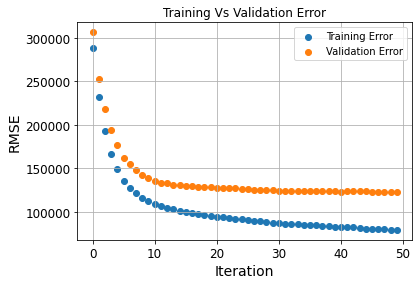

In [78]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

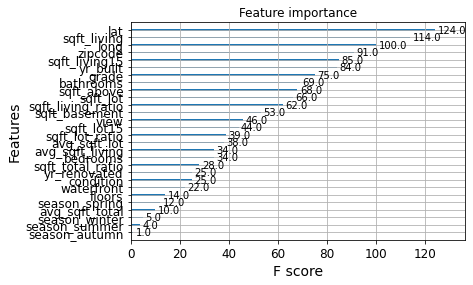

In [79]:
xgb.plot_importance(xgb_model)
plt.show()

### <font color=blue> 7.3. Tuning model
    
+ **learning_rate**: scales the contribution of each tree. It you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is the regularization technique called shrinkage. If there are not enough trees to fit the training set it may cause underfitting, while if having has too many trees it may cause overfitting
    
The following codes try to fit the model with 4 different learning rates:  0.05, 0.1, 0.3, 0.5

#### Setting values of hyperparameters for searching 

In [80]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    # 'bootstrap': [True],
    'max_depth': [6],
    'max_features': [8],
    'min_samples_leaf': [50],
    'min_samples_split': [100],
    'n_estimators': [100, 200, 300, 400, 500],
}
# Create a based model
xgb_model = XGBRegressor()
# Instantiate the grid search model
xgb_grid_search = GridSearchCV(estimator = xgb_model, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2) 
# Fit the grid search to the data
xgb_grid_search.fit(X_train, y_train)  

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.7s finished


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
        

#### View the hyperparameters and detailed information for the model

In [81]:
# view best score
print('R-Squared::{}'.format(xgb_grid_search.best_score_))
# View best hyperparameters
print('Best hyperparameters::\n{}'.format(xgb_grid_search.best_params_))
# View detailed information of each iteration of GridSearchCV()
gridsearch_df = pd.DataFrame(xgb_grid_search.cv_results_)
gridsearch_df.head(5)

R-Squared::0.8695823041125674
Best hyperparameters::
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.530489,0.094943,0.042557,0.004784,6,8,50,100,100,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.883055,0.883146,0.849370,0.912872,0.858047,0.905319,0.885051,0.776450,0.899376,0.843138,0.869582,0.038155,1
1,2.576271,0.020116,0.045782,0.002801,6,8,50,100,200,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.881903,0.883111,0.845770,0.911748,0.858568,0.905263,0.883932,0.774276,0.898527,0.841458,0.868455,0.038703,2
2,4.055318,0.145336,0.060489,0.017199,6,8,50,100,300,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.880920,0.882554,0.845856,0.910940,0.858182,0.904408,0.883105,0.774596,0.897518,0.840541,0.867862,0.038357,3
3,5.093969,0.090847,0.060030,0.004078,6,8,50,100,400,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.880220,0.881893,0.845867,0.910542,0.858021,0.903391,0.882875,0.773875,0.897143,0.839798,0.867363,0.038361,4
4,5.668342,0.840074,0.055363,0.014587,6,8,50,100,500,"{'max_depth': 6, 'max_features': 8, 'min_sampl...",0.879830,0.881888,0.845259,0.910073,0.857311,0.903263,0.882447,0.773924,0.897258,0.839314,0.867057,0.038350,5


#### View grid search results

In [82]:
results = xgb_grid_search.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 100} 0.8696 0.0382
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 200} 0.8685 0.0387
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 300} 0.8679 0.0384
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 400} 0.8674 0.0384
{'max_depth': 6, 'max_features': 8, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 500} 0.8671 0.0383


#### Train model with the best paramters

In [83]:
xgb_model = xgb_grid_search.best_estimator_
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_features=8, max_leaves=None,
             min_child_weight=None, min_samples_leaf=50, min_samples_split=100,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=100, ...)

### <font color=blue>7.4. Prediction

In [84]:
pred_train = xgb_model.predict(X_train)
print('Train prediction: ',list(pred_train[0:5]))
print('Train true label: ',list(y_train[0:5]))
print()
pred_test = xgb_model.predict(X_test)
print('Test prediction: ',list(pred_test[0:5]))
print('Test true label: ',list(y_test[0:5]))
print()
print('Average house price: ', y_train.median())

Train prediction:  [601010.56, 248737.25, 328248.5, 505387.62, 750951.25]
Train true label:  [626000.0, 225000.0, 289571.0, 552500.0, 700000.0]

Test prediction:  [322064.7, 1763795.2, 478357.3, 639113.44, 818769.25]
Test true label:  [297000.0, 1578000.0, 562100.0, 631500.0, 780000.0]

Average house price:  455000.0


### <font color=blue> 7.5. Model Evaluation

#### R-squared

In [85]:
train_score = xgb_model.score(X_train, y_train)
test_score = xgb_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9803
Test R-squared: 0.9023


#### MSE, RMSE

In [86]:
print('linear train mse: {}'.format(mean_squared_error(y_train, pred_train)))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(y_train, pred_train))))
print()
print('linear test mse: {}'.format(mean_squared_error(y_test,pred_test)))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(y_test, pred_test))))

linear train mse: 2673812200.512577
linear train rmse: 51708.917997890625

linear test mse: 11613297736.025944
linear test rmse: 107765.01165047004


#### Residual plot

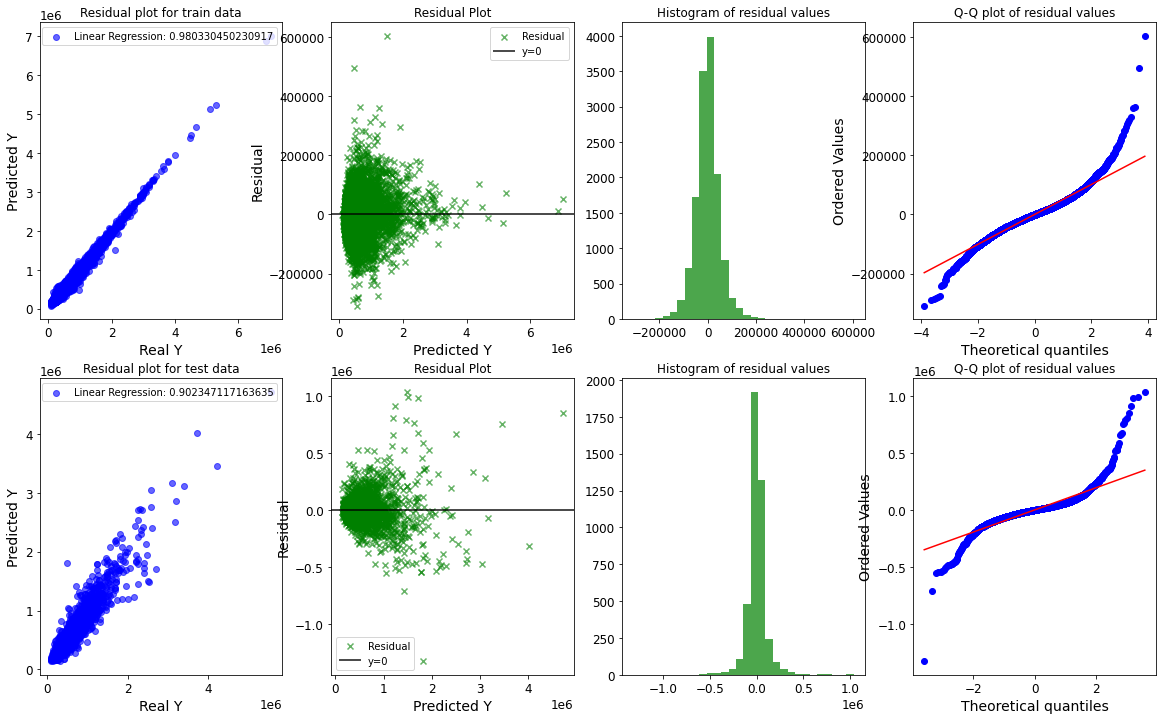

In [87]:
fig, axes = plt.subplots(2,4,figsize=(20,12))
plot_residual(axes[0][0],axes[0][1],axes[0][2],axes[0][3],pred_train,y_train,'Linear Regression: {}'.format(train_score),'Residual plot for train data')
plot_residual(axes[1][0],axes[1][1],axes[1][2],axes[1][3],pred_test,y_test,'Linear Regression: {}'.format(test_score),'Residual plot for test data')
fig.show()

### <font color=blue> 7.6. Feature Importance 

Text(0.5, 1.0, 'Feature Importance')

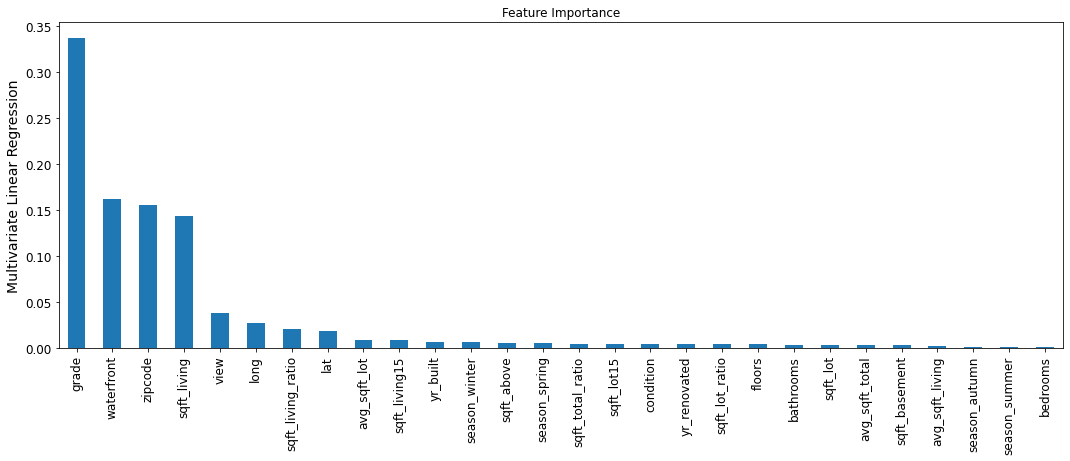

In [88]:
feature_importance = pd.Series(np.abs(xgb_model.feature_importances_))
feature_importance.index = TRAIN_VARS
feature_importance.sort_values(inplace=True,ascending=False)
feature_importance.plot.bar(figsize=(18,6))
plt.ylabel('Multivariate Linear Regression')
plt.title('Feature Importance')

### <font color=blue> 7.7. Cross Validation

In [89]:
# Cross Validation
cv_scores = cross_val_score(xgb_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(xgb_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))
pd.Series(cv_scores).describe()

R2 score:  [0.88305521 0.88314579 0.84937017 0.91287197 0.85804703 0.90531862
 0.88505077 0.77644966 0.89937628 0.84313754]
Average R2 score:  0.87
Average RMSE score:  132138.03


count    10.000000
mean      0.869582
std       0.040219
min       0.776450
25%       0.851539
50%       0.883101
75%       0.895795
max       0.912872
dtype: float64

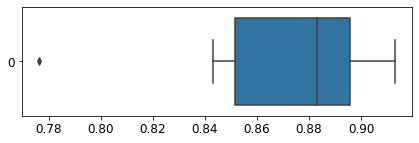

In [90]:
plt.figure(figsize=(7,2))
sns.boxplot(data=cv_scores, orient='h')
plt.show()

### <font color=blue> 7.8. Gradient Boosting with Early stopping

In [91]:
xgb = XGBRegressor(max_depth=5, warm_start=True, random_state=42, min_samples_leaf=50)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(300, 500, 20):
    xgb.n_estimators = n_estimators
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print(n_estimators, ": ", xgb.score(X_test, y_test))
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

300 :  0.8977787992667545
320 :  0.8977627863717597
340 :  0.8977364783444204
360 :  0.897696806797031
380 :  0.8973088359354304
400 :  0.8971328156089918


In [92]:
print(xgb.n_estimators)
print("Minimum validation MSE:", min_val_error)

400
Minimum validation MSE: 12156581603.827272


In [93]:
xgb_model = XGBRegressor(max_depth=5, warm_start=True, random_state=42, 
                                 min_samples_leaf=50, n_estimators=280)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, min_samples_leaf=50, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=280,
             n_jobs=None, num_parallel_tree=None, ...)

In [94]:
train_score = xgb_model.score(X_train, y_train)
test_score = xgb_model.score(X_test, y_test)
print('Train R-squared: %.4f' % train_score)
print('Test R-squared: %.4f' % test_score)

Train R-squared: 0.9879
Test R-squared: 0.8975


In [95]:
# Cross Validation
cv_scores = cross_val_score(xgb_model,X_train,y_train,scoring='r2',cv=10)
rmse = np.sqrt(-cross_val_score(xgb_model,X_train, y_train,scoring="neg_mean_squared_error", cv =10))
print('R2 score: ', cv_scores)
print('Average R2 score: ', np.round(np.mean(cv_scores),2))
print('Average RMSE score: ',np.round(np.mean(rmse),2))

R2 score:  [0.88636704 0.89004127 0.85347773 0.89897263 0.84413357 0.90499109
 0.87577061 0.79157549 0.89513131 0.86661428]
Average R2 score:  0.87
Average RMSE score:  131786.29


---
---
<a id="dnn"></a>
[content table](#content_table)
# <font color=red>8. ANN/DNN
  
### <font color=blue> 8.1.  Introduction

In [6]:
file_name = 'kc_house_data.csv'

df = pd.read_csv(file_name)
print(df.shape)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

print(train_df.shape, test_df.shape)

(21613, 21)
(17290, 21) (4323, 21)


In [98]:


train_df = data_preparation(train_df)
test_df = data_preparation(test_df)

In [99]:
y_train = train_df[target_var]
y_test = test_df[target_var]

X_train = preprocessing_training_data(train_df, num_vars, cat_vars, 1)
train_vars = pd.read_csv(training_path + 'final_train_vars_' + 'v1' + '.csv')
train_vars = list(train_vars.feature)
X_train = X_train[train_vars]
X_test = preprocessing_test_data(test_df, num_vars, cat_vars, 1)
X_test = X_test[train_vars]
print(X_train.shape, X_test.shape)

(17290, 28) (4323, 28)


In [102]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,zipcode,avg_sqft_living,sqft_living_ratio,avg_sqft_lot,sqft_lot_ratio,avg_sqft_total,sqft_total_ratio,waterfront,season_autumn,season_spring,season_summer,season_winter
0,0.090909,0.1250,0.096604,0.003023,0.0,0.0,0.75,0.500000,0.085526,0.103734,0.347826,0.0,0.865852,0.162636,0.240063,0.006581,0.739130,0.153318,0.113821,0.053922,0.006242,0.063590,0.006123,0,0,0,0,1
1,0.090909,0.3125,0.112453,0.006348,0.0,0.0,0.75,0.583333,0.100877,0.118257,0.695652,0.0,0.645810,0.304420,0.334617,0.010395,0.942029,0.643021,0.072782,0.187261,0.006096,0.216830,0.005886,0,0,0,1,0
2,0.090909,0.1875,0.060377,0.005659,0.0,0.0,0.50,0.583333,0.087719,0.000000,0.756522,0.0,0.755509,0.398666,0.229557,0.010581,0.797101,0.542334,0.040842,0.178251,0.005631,0.203763,0.005144,0,0,1,0,0
3,0.121212,0.3125,0.144906,0.003973,0.4,0.0,0.50,0.583333,0.210526,0.000000,0.808696,0.0,0.425768,0.276063,0.275083,0.007293,0.173913,0.212815,0.155907,0.125964,0.005060,0.132978,0.005710,0,0,0,1,0
4,0.090909,0.3125,0.113962,0.002570,0.4,0.0,0.50,0.500000,0.104167,0.116183,0.739130,0.0,0.788322,0.126772,0.243565,0.004723,0.913043,0.189931,0.126846,0.015724,0.007785,0.026309,0.007369,0,1,0,0,0


### <font color=blue>  8.2. Import library

In [103]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K

In [104]:
def plot_history(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### <font color=blue> 8.3. Construct architecture

### <font color=green> 1 hidden layer

In [105]:
def dnn_model1(dim1,n_epochs, batch_size):   
    keras.backend.clear_session()
    tf.keras.backend.clear_session
    tf.random.set_seed(9)
    np.random.seed(9)
    
    dnn = Sequential()
    dnn.add(Dense(dim1, input_dim=len(TRAIN_VARS), activation='relu'))
    dnn.add(Dense(1, activation='relu'))
    print(dnn.summary())
    
    dnn.compile(loss='mse', optimizer='adam', metrics=['mae'])
    t_ini = datetime.datetime.now()
    history = dnn.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, validation_split=0.2)
    t_fin = datetime.datetime.now()
    print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
    plot_history(history)
    performance_evaluation(X_train, X_test, y_train, y_test, dnn)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                580       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1384/1384 [==============================] - 2s 1ms/step - loss: 439675682816.0000 - mae: 544703.0625 - val_loss: 406972137472.0000 - val_mae: 534324.1875
Epoch 2/30
1384/1384 [==============================] - 1s 913us/step - loss: 438902489088.0000 - mae: 544045.0625 - val_loss: 405923201024.0000 - val_mae: 533410.7500
Epoch 3/30
1384/1384 [==============================] - 1s 1ms/step - loss: 437576794112.0000 - mae: 542916.9375 - val_loss: 404408401920.0000 - val_mae: 532089.0000
Epoch 4/30
1384

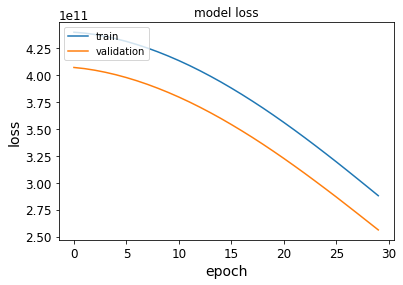

Train mse: 278380310976.83685
Train rmse: 527617.5802386013

Test mse: 263878345358.25244
Test rmse: 513690.90449243155


In [106]:
dnn_model1(20, n_epochs=30, batch_size=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2900      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
433/433 [==============================] - 1s 1ms/step - loss: 439748001792.0000 - mae: 544765.2500 - val_loss: 407166058496.0000 - val_mae: 534493.7500
Epoch 2/30
433/433 [==============================] - 1s 1ms/step - loss: 439294656512.0000 - mae: 544380.6875 - val_loss: 406509060096.0000 - val_mae: 533923.0625
Epoch 3/30
433/433 [==============================] - 1s 1ms/step - loss: 438423027712.0000 - mae: 543640.3750 - val_loss: 405473918976.0000 - val_mae: 533022.5625
Epoch 4/30
433/433 

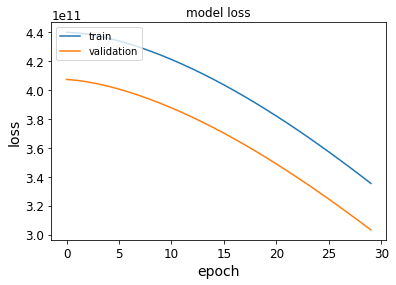

Train mse: 326682858660.9688
Train rmse: 571561.7715181526

Test mse: 307517013694.7035
Test rmse: 554542.1658401672


In [107]:
dnn_model1(100, n_epochs=30, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               5800      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1384/1384 [==============================] - 3s 2ms/step - loss: 438504423424.0000 - mae: 543692.9375 - val_loss: 403572162560.0000 - val_mae: 531356.0000
Epoch 2/30
1384/1384 [==============================] - 2s 1ms/step - loss: 431270723584.0000 - mae: 537491.0000 - val_loss: 393756966912.0000 - val_mae: 522698.6250
Epoch 3/30
1384/1384 [==============================] - 2s 1ms/step - loss: 418956345344.0000 - mae: 526791.6875 - val_loss: 379833778176.0000 - val_mae: 510178.9375
Epoch 4/30
13

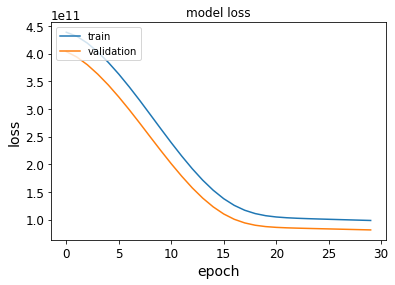

Train mse: 94814551368.55608
Train rmse: 307919.71578409214

Test mse: 78711512856.72133
Test rmse: 280555.72148277663


In [108]:
dnn_model1(200, n_epochs=30, batch_size=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2900      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1384/1384 [==============================] - 2s 970us/step - loss: 439137501184.0000 - mae: 544240.5625 - val_loss: 405404778496.0000 - val_mae: 532957.6250
Epoch 2/30
1384/1384 [==============================] - 1s 868us/step - loss: 435355025408.0000 - mae: 541009.1875 - val_loss: 400252076032.0000 - val_mae: 528442.7500
Epoch 3/30
1384/1384 [==============================] - 1s 868us/step - loss: 428866043904.0000 - mae: 535432.5000 - val_loss: 392872460288.0000 - val_mae: 521912.4062
Epoch 4

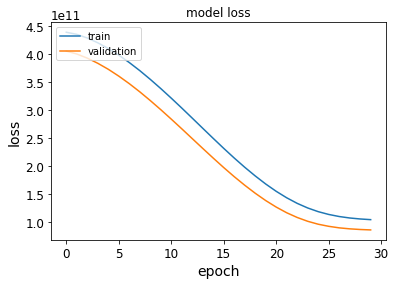

Train mse: 100075551828.99454
Train rmse: 316347.20139270165

Test mse: 86133157397.17802
Test rmse: 293484.5096375242


In [109]:
dnn_model1(100, n_epochs=30, batch_size=10)

### <font color=green> 2 hidden layers

In [110]:
def dnn_model2(dim1,n_epochs, batch_size):   
    keras.backend.clear_session()
    tf.keras.backend.clear_session
    tf.random.set_seed(9)
    np.random.seed(9)
    
    dnn = Sequential()
    dnn.add(Dense(dim1, input_dim=len(TRAIN_VARS), activation='relu'))
    dnn.add(Dense(50, activation='relu'))
    dnn.add(Dense(1, activation='relu'))
    print(dnn.summary())
    
    dnn.compile(loss='mse', optimizer='adam', metrics=['mae'])
    t_ini = datetime.datetime.now()
    history = dnn.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,  verbose=1, validation_split=0.2)
    t_fin = datetime.datetime.now()
    print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))
    plot_history(history)
    performance_evaluation(X_train, X_test, y_train, y_test, dnn)

#### Select number of neurons in the first hidden layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                725       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,076
Trainable params: 2,076
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
433/433 [==============================] - 1s 2ms/step - loss: 439332241408.0000 - mae: 544406.5625 - val_loss: 405300510720.0000 - val_mae: 532871.7500
Epoch 2/50
433/433 [==============================] - 0s 1ms/step - loss: 431408578560.0000 - mae: 537611.5625 - val_loss: 389805801472.0000 - val_mae: 519215.0312
Epoch 3/50
433/433 [==============================]

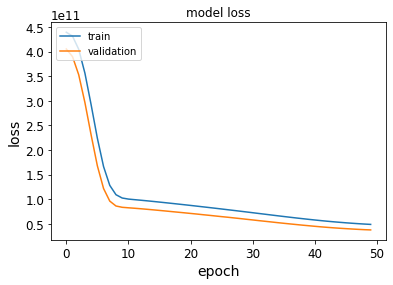

Train mse: 46343066098.72415
Train rmse: 215274.39722067313

Test mse: 38375090926.33996
Test rmse: 195895.61232028643


In [111]:
dnn_model2(25, n_epochs=50, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1450      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 4,051
Trainable params: 4,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
433/433 [==============================] - 1s 2ms/step - loss: 438548725760.0000 - mae: 543727.5000 - val_loss: 401904959488.0000 - val_mae: 529901.8125
Epoch 2/50
433/433 [==============================] - 1s 2ms/step - loss: 418212904960.0000 - mae: 526033.5625 - val_loss: 363428610048.0000 - val_mae: 495118.1250
Epoch 3/50
433/433 [==============================]

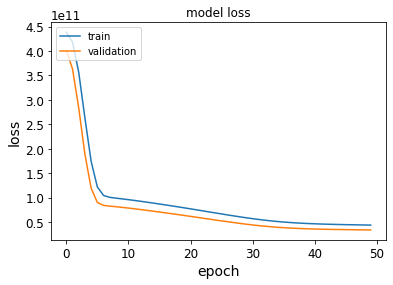

Train mse: 41524084345.43653
Train rmse: 203774.59200164414

Test mse: 35442410907.57716
Test rmse: 188261.54920104414


In [112]:
dnn_model2(50, n_epochs=50, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               5800      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
433/433 [==============================] - 1s 2ms/step - loss: 435071549440.0000 - mae: 540699.1250 - val_loss: 387687514112.0000 - val_mae: 517312.3438
Epoch 2/50
433/433 [==============================] - 1s 2ms/step - loss: 368554573824.0000 - mae: 479437.3125 - val_loss: 271305850880.0000 - val_mae: 400499.4375
Epoch 3/50
433/433 [=============================

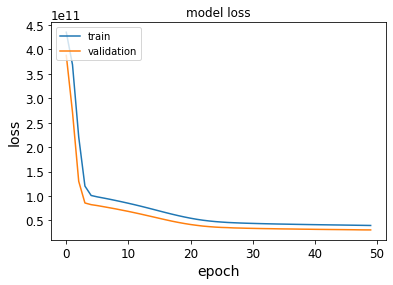

Train mse: 37777831784.336426
Train rmse: 194365.20209218631

Test mse: 33359609192.10354
Test rmse: 182646.1310625099


In [113]:
dnn_model2(200, n_epochs=50, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               5800      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,901
Trainable params: 15,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
433/433 [==============================] - 1s 1ms/step - loss: 435071549440.0000 - mae: 540699.1250 - val_loss: 387687514112.0000 - val_mae: 517312.3438
Epoch 2/200
433/433 [==============================] - 1s 1ms/step - loss: 368554573824.0000 - mae: 479437.3125 - val_loss: 271305850880.0000 - val_mae: 400499.4375
Epoch 3/200
433/433 [==========================

433/433 [==============================] - 1s 2ms/step - loss: 33120073728.0000 - mae: 105177.0391 - val_loss: 25322852352.0000 - val_mae: 98543.0859
Epoch 97/200
433/433 [==============================] - 1s 3ms/step - loss: 32986802176.0000 - mae: 105308.7188 - val_loss: 25239058432.0000 - val_mae: 98103.4531
Epoch 98/200
433/433 [==============================] - 1s 2ms/step - loss: 32882268160.0000 - mae: 104921.2734 - val_loss: 25159366656.0000 - val_mae: 97907.8281
Epoch 99/200
433/433 [==============================] - 1s 2ms/step - loss: 32763402240.0000 - mae: 104855.1875 - val_loss: 25084078080.0000 - val_mae: 97800.7188
Epoch 100/200
433/433 [==============================] - 1s 2ms/step - loss: 32679063552.0000 - mae: 104540.5000 - val_loss: 25003872256.0000 - val_mae: 97848.3750
Epoch 101/200
433/433 [==============================] - 1s 3ms/step - loss: 32568551424.0000 - mae: 104549.8750 - val_loss: 24933765120.0000 - val_mae: 97431.5703
Epoch 102/200
433/433 [==========

433/433 [==============================] - 0s 1ms/step - loss: 25589544960.0000 - mae: 91110.7266 - val_loss: 20186984448.0000 - val_mae: 86512.4375
Epoch 197/200
433/433 [==============================] - 0s 1ms/step - loss: 25550346240.0000 - mae: 91086.2578 - val_loss: 20179836928.0000 - val_mae: 85982.8672
Epoch 198/200
433/433 [==============================] - 0s 1ms/step - loss: 25484812288.0000 - mae: 90936.0781 - val_loss: 20131016704.0000 - val_mae: 86088.7969
Epoch 199/200
433/433 [==============================] - 0s 1ms/step - loss: 25463572480.0000 - mae: 90805.1094 - val_loss: 20122109952.0000 - val_mae: 86449.0156
Epoch 200/200
433/433 [==============================] - 0s 1ms/step - loss: 25430235136.0000 - mae: 90855.6094 - val_loss: 20082851840.0000 - val_mae: 86164.7188
Time to run the model: 141.834379 Sec.
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


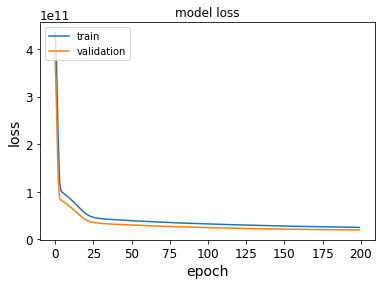

Train mse: 24291057382.28248
Train rmse: 155855.8865820681

Test mse: 32161613316.217392
Test rmse: 179336.59223989228


In [114]:
dnn_model2(200, n_epochs=200, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 250)               7250      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12550     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 19,851
Trainable params: 19,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
433/433 [==============================] - 1s 1ms/step - loss: 433681596416.0000 - mae: 539476.3125 - val_loss: 382058102784.0000 - val_mae: 512242.1875
Epoch 2/300
433/433 [==============================] - 0s 1ms/step - loss: 350438621184.0000 - mae: 461000.0000 - val_loss: 240857808896.0000 - val_mae: 364310.0312
Epoch 3/300
433/433 [==========================

433/433 [==============================] - 1s 2ms/step - loss: 28312600576.0000 - mae: 94952.1250 - val_loss: 21847345152.0000 - val_mae: 89131.1719
Epoch 97/300
433/433 [==============================] - 1s 3ms/step - loss: 28146360320.0000 - mae: 94923.3984 - val_loss: 21770057728.0000 - val_mae: 88574.8516
Epoch 98/300
433/433 [==============================] - 1s 2ms/step - loss: 28004116480.0000 - mae: 94394.4219 - val_loss: 21680381952.0000 - val_mae: 88420.6953
Epoch 99/300
433/433 [==============================] - 1s 2ms/step - loss: 27861063680.0000 - mae: 94345.0234 - val_loss: 21599959040.0000 - val_mae: 88200.2969
Epoch 100/300
433/433 [==============================] - 1s 1ms/step - loss: 27743807488.0000 - mae: 93937.0234 - val_loss: 21500575744.0000 - val_mae: 88307.0781
Epoch 101/300
433/433 [==============================] - 1s 2ms/step - loss: 27611125760.0000 - mae: 93839.9844 - val_loss: 21426472960.0000 - val_mae: 87863.3672
Epoch 102/300
433/433 [================

433/433 [==============================] - 1s 2ms/step - loss: 21859852288.0000 - mae: 83009.2188 - val_loss: 18521884672.0000 - val_mae: 79770.0469
Epoch 197/300
433/433 [==============================] - 1s 2ms/step - loss: 21841031168.0000 - mae: 83045.5469 - val_loss: 18533931008.0000 - val_mae: 79373.1953
Epoch 198/300
433/433 [==============================] - 1s 2ms/step - loss: 21788170240.0000 - mae: 82892.2891 - val_loss: 18502909952.0000 - val_mae: 79618.0938
Epoch 199/300
433/433 [==============================] - 1s 2ms/step - loss: 21779240960.0000 - mae: 82865.3906 - val_loss: 18499284992.0000 - val_mae: 79859.7734
Epoch 200/300
433/433 [==============================] - 1s 3ms/step - loss: 21767665664.0000 - mae: 82933.1094 - val_loss: 18487973888.0000 - val_mae: 79725.5312
Epoch 201/300
433/433 [==============================] - 1s 3ms/step - loss: 21724669952.0000 - mae: 82804.2734 - val_loss: 18500622336.0000 - val_mae: 79977.5000
Epoch 202/300
433/433 [=============

433/433 [==============================] - 1s 2ms/step - loss: 19865872384.0000 - mae: 80178.7031 - val_loss: 18144307200.0000 - val_mae: 77595.6953
Epoch 297/300
433/433 [==============================] - 0s 1ms/step - loss: 19841320960.0000 - mae: 80168.5312 - val_loss: 18139277312.0000 - val_mae: 77615.1484
Epoch 298/300
433/433 [==============================] - 0s 1ms/step - loss: 19829764096.0000 - mae: 80178.3203 - val_loss: 18167814144.0000 - val_mae: 77410.8125
Epoch 299/300
433/433 [==============================] - 1s 1ms/step - loss: 19823603712.0000 - mae: 80155.4297 - val_loss: 18129780736.0000 - val_mae: 77708.5078
Epoch 300/300
433/433 [==============================] - 1s 1ms/step - loss: 19800700928.0000 - mae: 80160.0078 - val_loss: 18129330176.0000 - val_mae: 77598.2734
Time to run the model: 220.497711 Sec.
dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


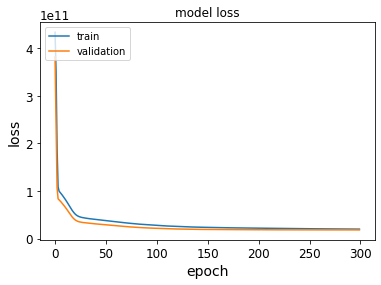

Train mse: 19413213455.708927
Train rmse: 139331.30823942236

Test mse: 61339568468.447014
Test rmse: 247668.26294147383


In [115]:
dnn_model2(250, n_epochs=300, batch_size=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 23,801
Trainable params: 23,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
433/433 [==============================] - 1s 2ms/step - loss: 439821828096.0000 - mae: 544829.2500 - val_loss: 407385276416.0000 - val_mae: 534684.2500
Epoch 2/30
433/433 [==============================] - 1s 1ms/step - loss: 439821828096.0000 - mae: 544828.9375 - val_loss: 407385276416.0000 - val_mae: 534684.2500
Epoch 3/30
433/433 [=============================

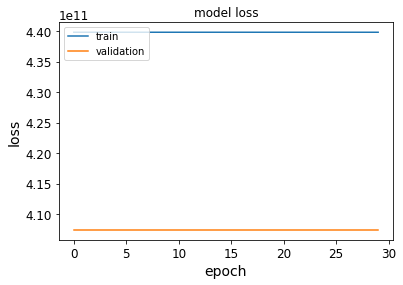

Train mse: 433334469673.47015
Train rmse: 658281.4517161107

Test mse: 399022011977.41223
Test rmse: 631681.8914433215


In [116]:
dnn_model2(300, n_epochs=30, batch_size=0)

In [117]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )